In [1]:
!pip install scikit-optimize

In [2]:
import math
import pprint
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.callbacks import DeltaYStopper, DeadlineStopper

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Load, clean, and prepare data

In [3]:
# Load the dataset
file_path = 'games.csv'
data = pd.read_csv(file_path)

In [4]:
# Filter dataset for regular season games
data = data[data['game_type'] == 'REG']

# Filter for columns we aren interested in
columns = ['week', 'weekday', 'gametime', 'away_team', 'home_team', 'div_game', 'roof', 'surface', 'temp', 'wind', 'home_score', 'away_score']
data = data[columns]

# Convert game time to numeric
def convert_gametime(gametime_str):
  """Converts gametime string to decimal"""
  try:
    hours, minutes = map(int, gametime_str.split(':'))
    return hours + minutes / 60
  except:
    return None  # Return None for invalid values

data['gametime'] = data['gametime'].apply(convert_gametime)

# Remove rows with no target
data = data.dropna(subset=['home_score', 'away_score'])

# One hot encode categorical features
data = pd.get_dummies(data, columns=['weekday', 'away_team', 'home_team', 'div_game', 'roof', 'surface'], drop_first=True)

# Select relevant features and target
target = data['home_score'] + data['away_score']
data = data.drop(columns=['home_score','away_score'])

In [5]:
# Create LightGBM dataset
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

## Exploratory Data Analysis

In [6]:
# look at number of rows/columns in the dataset and the target
print(f"data:   {data.shape}")
print(f"target: {target.shape}")

data:   (6515, 90)
target: (6515,)


In [7]:
# View feature data types
data.dtypes

,0
week,int64
gametime,float64
temp,float64
wind,float64
weekday_Monday,bool
weekday_Saturday,bool
weekday_Sunday,bool
weekday_Thursday,bool
weekday_Tuesday,bool
weekday_Wednesday,bool


In [8]:
# Feature correlations with the target
correlations = data.corrwith(target)

sorted_correlations = correlations.abs().sort_values(ascending=False).index
sorted_correlations_with_sign = correlations.loc[sorted_correlations]

print("Features sorted by correlation with the target:\n")
for feature, corr in sorted_correlations_with_sign.items():
    print(f"{feature}: {corr:.4f}")

Features sorted by correlation with the target:

roof_outdoors: -0.1145
wind: -0.0911
roof_dome: 0.0888
surface_grass: -0.0698
home_team_NO: 0.0657
home_team_CLE: -0.0606
away_team_IND: 0.0521
away_team_PIT: -0.0517
surface_matrixturf: 0.0511
div_game_1: -0.0503
surface_fieldturf: 0.0457
away_team_GB: 0.0456
home_team_DAL: 0.0430
home_team_JAX: -0.0427
away_team_BAL: -0.0412
surface_astroplay: -0.0396
home_team_DET: 0.0391
away_team_NYJ: -0.0388
away_team_NO: 0.0386
home_team_NYJ: -0.0375
surface_sportturf: 0.0364
away_team_KC: 0.0361
away_team_CHI: -0.0328
gametime: 0.0318
home_team_CAR: -0.0308
home_team_CHI: -0.0303
home_team_ATL: 0.0272
roof_open: 0.0271
home_team_LV: 0.0270
home_team_IND: 0.0259
home_team_BAL: -0.0257
home_team_TB: -0.0255
home_team_MIA: -0.0254
home_team_STL: 0.0236
away_team_LA: 0.0231
weekday_Sunday: -0.0216
away_team_MIN: 0.0214
away_team_DAL: -0.0209
away_team_SD: 0.0209
away_team_CIN: -0.0199
home_team_WAS: -0.0199
home_team_BUF: -0.0184
home_team_GB: 0.0181

In [9]:
# Unique values
(pd.concat([data.apply(lambda x: len(x.unique())),
            X_test.apply(lambda x: len(x.unique()))
           ], axis="columns")
 .rename(columns={0: "train", 1:"test"}))

,train,test
week,18,18
gametime,41,28
temp,102,84
wind,39,29
weekday_Monday,2,2
weekday_Saturday,2,2
weekday_Sunday,2,2
weekday_Thursday,2,2
weekday_Tuesday,2,2
weekday_Wednesday,2,1


In [10]:
# Number of values in test but not train (non-zero)
for col in data.columns.tolist():
    mismatched_codes = len(np.setdiff1d(data[col].unique(), X_test[col].unique()))
    if mismatched_codes > 0:
        print(f"{col:20} {mismatched_codes:4}")

gametime               14
temp                   19
wind                   11
weekday_Wednesday       1


In [11]:
# Missing values
(pd.concat([data.isna().sum(),
            X_test.isna().sum()], axis="columns")
 .rename(columns={0: "train", 1: "test"})
 .loc[lambda df: (df["train"] != 0) | (df["test"] != 0)])

,train,test
gametime,248,61
temp,1824,367
wind,1824,367


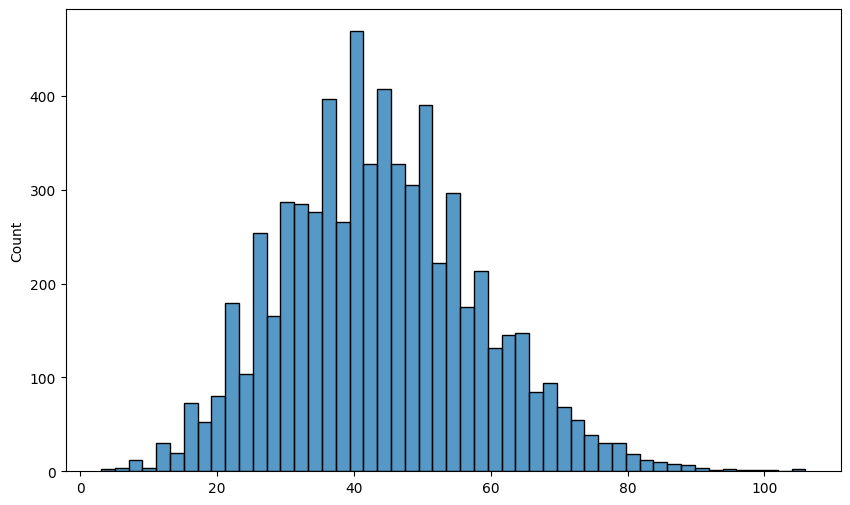

In [12]:
# Target distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(target, ax=ax)
plt.show()

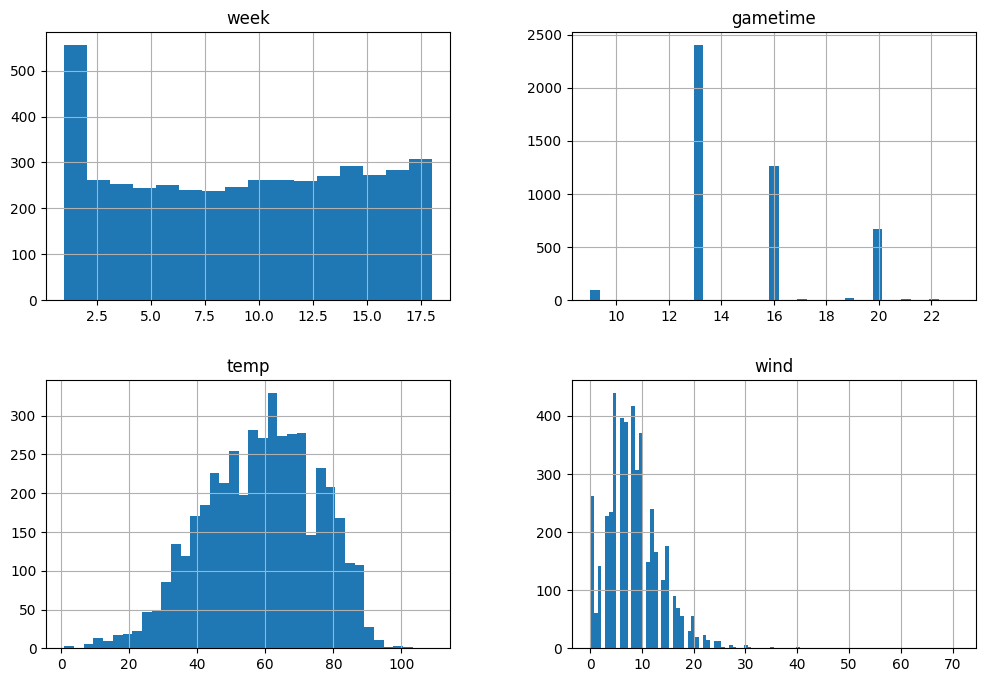

In [13]:
# Subset the dataframe to include only the desired columns
columns_to_plot = ['week', 'gametime', 'temp', 'wind']
df_subset = data[columns_to_plot]

# Calculate the number of rows and columns for the grid layout
num_cols = 2
num_rows = math.ceil(len(df_subset.columns) / num_cols)

# Plot histograms for the selected columns
_ = df_subset.dropna().astype(int).hist(
    bins="auto", figsize=(12, 4 * num_rows), layout=(num_rows, num_cols))

## Train

In [14]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performance of different optimizers.

    Parameters:
    - optimizer: a sklearn or skopt optimizer
    - X: the training set (features)
    - y: the target variable
    - title: a string label for the experiment
    - callbacks: optional list of callbacks for the optimizer

    Returns:
    - best_params: dictionary of the best parameters
    """
    start = time()

    # Fit the optimizer with or without callbacks
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)

    # Convert cv_results_ into a DataFrame for easier handling
    results_df = pd.DataFrame(optimizer.cv_results_)

    # Retrieve key metrics
    best_index = optimizer.best_index_
    best_score = optimizer.best_score_
    best_params = optimizer.best_params_
    best_score_std = results_df.loc[best_index, "std_test_score"]
    mean_fit_time = np.mean(results_df["mean_fit_time"])

    # Print the performance summary
    print(
        (f"{title} took {time() - start:.2f} seconds, candidates checked: {len(results_df)}, "
         f"best CV score: {best_score:.3f} ± {best_score_std:.3f}")
    )
    print(f"Mean fit time per candidate: {mean_fit_time:.2f} seconds")
    print("Best parameters:")
    pprint.pprint(best_params)
    print()

    return best_params


In [15]:
# Converting average precision score into a scorer suitable for model selection
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [16]:
# Setting a 5-fold stratified cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [17]:
clf = lgb.LGBMRegressor(
        objective='regression',
        metric='mae',
        boosting_type='gbdt',
        n_jobs=1,
        verbose=-1,
        random_state=42
    )

In [18]:
search_spaces={
        'learning_rate': (0.01, 0.3, 'log-uniform'),
        'n_estimators': (50, 500),
        'max_depth': (3, 12),
        'num_leaves': (20, 1000),
        'min_child_samples': (5, 50),
        'subsample': (0.6, 1.0, 'uniform'),
        'colsample_bytree': (0.6, 1.0, 'uniform'),
        'reg_alpha': (1e-8, 10.0, 'log-uniform'),
        'reg_lambda': (1e-8, 10.0, 'log-uniform')
    }

In [19]:
opt = BayesSearchCV(estimator=clf,
                    search_spaces=search_spaces,
                    scoring=mae_scorer,
                    cv=kf,
                    n_iter=3000,
                    n_points=3,
                    n_jobs=-1,
                    iid=False,
                    return_train_score=False,
                    refit=False,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

In [20]:
# Setup callbacks to stop optimization if progress stagnates
overdone_control = DeltaYStopper(delta=0.0001)               # Stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 45)     # 45 minute time limit
best_params = report_perf(opt, X_train, y_train,'LightGBM', callbacks=[overdone_control, time_limit_control])

LightGBM took 2669.13 seconds, candidates checked: 264, best CV score: -11.130 ± 0.106
Mean fit time per candidate: 0.29 seconds
Best parameters:
OrderedDict([('colsample_bytree', 0.6),
             ('learning_rate', 0.035683014214506474),
             ('max_depth', 3),
             ('min_child_samples', 5),
             ('n_estimators', 162),
             ('num_leaves', 20),
             ('reg_alpha', 1e-08),
             ('reg_lambda', 1e-08),
             ('subsample', 1.0)])



In [21]:
# Create final model with optimized parameters
clf = lgb.LGBMRegressor(
        objective='regression',
        metric='mae',
        boosting_type='gbdt',
        n_jobs=1,
        verbose=-1,
        random_state=42,
        **best_params)

clf.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.6, learning_rate=0.035683014214506474,
              max_depth=3, metric='mae', min_child_samples=5, n_estimators=162,
              n_jobs=1, num_leaves=20, objective='regression', random_state=42,
              reg_alpha=1e-08, reg_lambda=1e-08, verbose=-1)

In [22]:
# Evaluate the performance
y_pred = clf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.4f}")

Test MAE: 11.0803
